# Lambda School Data Science - Ridge Regression

Regularize your way to a better tomorrow.

# Lecture

Data science depends on math, and math is generally focused on situations where:

1. a solution exists,
2. the solution is unique,
3. the solution's behavior changes continuously with the initial conditions.

These are known as [well-posed problems](https://en.wikipedia.org/wiki/Well-posed_problem), and are the sorts of assumptions so core in traditional techniques that it is easy to forget about them. But they do matter, as there can be exceptions:

1. no solution - e.g. no $x$ such that $Ax = b$
2. multiple solutions - e.g. several $x_1, x_2, ...$ such that $Ax = b$
3. "chaotic" systems - situations where small changes in initial conditions interact and reverberate in essentially unpredictable ways - for instance, the difficulty in longterm predictions of weather (N.B. not the same thing as longterm predictions of *climate*) - you can think of this as models that fail to generalize well, because they overfit on the training data (the initial conditions)

Problems suffering from the above are called ill-posed problems. Relating to linear algebra and systems of equations, the only truly well-posed problems are those with a single unique solution.

![Intersecting lines](https://upload.wikimedia.org/wikipedia/commons/c/c0/Intersecting_Lines.svg)

Think for a moment - what would the above plot look like if there was no solution? If there were multiple solutions? And how would that generalize to higher dimensions?

A lot of what you covered with linear regression was about getting matrices into the right shape for them to be solvable in this sense. But some matrices just won't submit to this, and other problems may technically "fit" linear regression but still be violating the above assumptions in subtle ways.

[Overfitting](https://en.wikipedia.org/wiki/Overfitting) is in some ways a special case of this - an overfit model uses more features/parameters than is "justified" by the data (essentially by the *dimensionality* of the data, as measured by $n$ the number of observations). As the number of features approaches the number of observations, linear regression still "works", but it starts giving fairly perverse results. In particular, it results in a model that fails to *generalize* - and so the core goal of prediction and explanatory power is undermined.

How is this related to well and ill-posed problems? It's not clearly a no solution or multiple solution case, but it does fall in the third category - overfitting results in fitting to the "noise" in the data, which means the particulars of one random sample or another (different initial conditions )will result in dramatically different models.

## Stop and think - what are ways to address these issues?

Let's examine in the context of housing data.

In [0]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization!
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [0]:
df.shape

(506, 14)

In [0]:
# Let's try good old least squares!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis='columns')
y = df.Price

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

21.894831181729206

That seems like a pretty good score, but...

![Kitchen Sink](https://i.imgur.com/ZZxqhT1.jpg)

Chances are this doesn't generalize very well. You can verify this by splitting the data to properly test model validity.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

22.347018673376052
26.273991426429014


Oops! 💥

### What can we do?

- Use fewer features - sure, but it can be a lot of work to figure out *which* features, and (in cases like this) there may not be any good reason to really favor some features over another.
- Get more data! This is actually a pretty good approach in tech, since apps generate lots of data all the time (and we made this situation by artificially constraining our data). But for case studies, existing data, etc. it won't work.
- **Regularize!**

## Regularization just means "add bias"

OK, there's a bit more to it than that. But that's the core intuition - the problem is the model working "too well", so fix it by making it harder for the model!

It may sound strange - a technique that is purposefully "worse" - but in certain situations, it can really get results.

What's bias? In the context of statistics and machine learning, bias is when a predictive model fails to identify relationships between features and the output. In a word, bias is *underfitting*.

We want to add bias to the model because of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) - variance is the sensitivity of a model to the random noise in its training data (i.e. *overfitting*), and bias and variance are naturally (inversely) related. Increasing one will always decrease the other, with regards to the overall generalization error (predictive accuracy on unseen data).

Visually, the result looks like this:

![Regularization example plot](https://upload.wikimedia.org/wikipedia/commons/0/02/Regularization.svg)

The blue line is overfit, using more dimensions than are needed to explain the data and so much of the movement is based on noise and won't generalize well. The green line still fits the data, but is less susceptible to the noise - depending on how exactly we parameterize "noise" we may throw out actual correlation, but if we balance it right we keep that signal and greatly improve generalizability.

### Look carefully at the above plot and think of ways you can quantify the difference between the blue and green lines...


In [0]:
# Now with regularization via ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

21.895862166800143

In [0]:
# The score is a bit worse than OLS - but that's expected (we're adding bias)
# Let's try split

ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

26.192201358877668

In [0]:
# A little better (to same test split w/OLS) - can we improve it further?
# We just went with defaults, but as always there's plenty of parameters
help(Ridge)

Help on class Ridge in module sklearn.linear_model.ridge:

class Ridge(_BaseRidge, sklearn.base.RegressorMixin)
 |  Linear least squares with l2 regularization.
 |  
 |  Minimizes the objective function::
 |  
 |  ||y - Xw||^2_2 + alpha * ||w||^2_2
 |  
 |  This model solves a regression model where the loss function is
 |  the linear least squares function and regularization is given by
 |  the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
 |  This estimator has built-in support for multi-variate regression
 |  (i.e., when y is a 2d-array of shape [n_samples, n_targets]).
 |  
 |  Read more in the :ref:`User Guide <ridge_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alpha : {float, array-like}, shape (n_targets)
 |      Regularization strength; must be a positive float. Regularization
 |      improves the conditioning of the problem and reduces the variance of
 |      the estimates. Larger values specify stronger regularization.
 |      Alpha corresponds t

How to tune alpha? For now, let's loop and try values.

(For longterm/stretch/next week, check out [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).)

In [0]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

0 26.273991426429053
1 26.192201358877668
2 26.118328007697226
3 26.051117952293595
4 25.989569283205444
5 25.93287356811407
6 25.880372753122625
7 25.831526788692837
8 25.785889053385123
9 25.743087513207442
10 25.702810145277628
11 25.66479356379559
12 25.628814073392263
13 25.59468057863174
14 25.56222892458644
15 25.53131734932431
16 25.50182280665663
17 25.473637974726547
18 25.44666880864133
19 25.420832527348388
20 25.396055949160893
21 25.372274108781504
22 25.349429102822004
23 25.327469121742823
24 25.30634763462536
25 25.286022699825878
26 25.266456379775086
27 25.24761424230921
28 25.229464934192976
29 25.211979815108453
30 25.19513264248022
31 25.178899299197408
32 25.163257557659424
33 25.14818687468406
34 25.13366821272317
35 25.11968388357409
36 25.106217411385522
37 25.093253412260974
38 25.080777488180427
39 25.068776133307583
40 25.057236651039766
41 25.046147080399017
42 25.035496130566347
43 25.02527312253186
44 25.015467936977434
45 25.006070967630855
46 24.997073

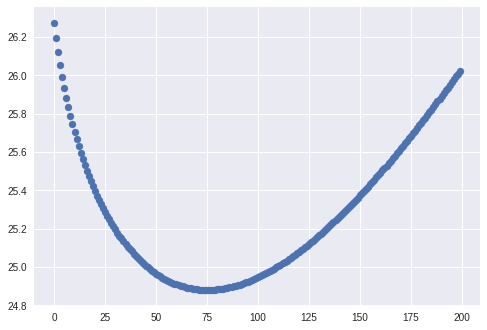

In [0]:
from matplotlib.pyplot import scatter
scatter(alphas, mses);

## What's the intuition? What are we doing?

The `alpha` parameter corresponds to the weight being given to the extra penalty being calculated by [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) (this parameter is sometimes referred to as $\lambda$ in the context of ridge regression).

Normal linear regression (OLS) minimizes the **sum of square error of the residuals**.

Ridge regression minimizes the **sum of square error of the residuals** *AND* **the squared slope of the fit model, times the alpha parameter**.

This is why the MSE for the first model in the for loop (`alpha=0`) is the same as the MSE for linear regression - it's the same model!

As `alpha` is increased, we give more and more penalty to a steep slope. In two or three dimensions this is fairly easy to visualize - beyond, think of it as penalizing coefficient size. Each coefficient represents the slope of an individual dimension (feature) of the model, so ridge regression is just squaring and summing those.

So while `alpha=0` reduces to OLS, as `alpha` approaches infinity eventually the penalty gets so extreme that the model will always output every coefficient as 0 (any non-zero coefficient resulting in a penalty that outweighs whatever improvement in the residuals), and just fit a flat model with intercept at the mean of the dependent variable.

Of course, what we want is somewhere in-between these extremes. Intuitively, what we want to do is apply an appropriate "cost" or penalty to the model for fitting parameters, much like adjusted $R^2$ takes into account the cost of adding complexity to a model. What exactly is an appropriate penalty will vary, so you'll have to put on your model comparison hat and give it a go!

PS - scaling the data helps, as that way this cost is consistent and can be added uniformly across features, and it is simpler to search for the `alpha` parameter.

### Bonus - magic! ✨

Ridge regression doesn't just reduce overfitting and help with the third aspect of well-posed problems (poor generalizability). It can also fix the first two (no unique solution)!

In [0]:
df_tiny = df.sample(10, random_state=27)
print(df_tiny.shape)
X = df_tiny.drop('Price', axis='columns')
y = df_tiny.Price

lin_reg = LinearRegression().fit(X, y)
lin_reg.score(X, y)  # Perfect multi-collinearity!
# NOTE - True OLS would 💥 here
# scikit protects us from actual error, but still gives a poor model

(10, 14)


1.0

In [0]:
ridge_reg = Ridge().fit(X, y)
ridge_reg.score(X, y)  # More plausible (not "perfect")

0.9760119331942763

In [0]:
# Using our earlier test split
mean_squared_error(y_test, lin_reg.predict(X_test))

103.04429449784261

In [0]:
# Ridge generalizes *way* better (and we've not even tuned alpha)
mean_squared_error(y_test, ridge_reg.predict(X_test))

41.79869373639458

## And a bit more math

The regularization used by Ridge Regression is also known as **$L^2$ regularization**, due to the squaring of the slopes being summed. This corresponds to [$L^2$ space](https://en.wikipedia.org/wiki/Square-integrable_function), a metric space of square-integrable functions that generally measure what we intuitively think of as "distance" (at least, on a plane) - what is referred to as Euclidean distance.

The other famous norm is $L^1$, also known as [taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry), because it follows the "grid" to measure distance like a car driving around city blocks (rather than going directly like $L^2$). When referred to as a distance this is called "Manhattan distance", and can be used for regularization (see [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics%29), which [uses the $L^1$ norm](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when)).

All this comes down to - regularization means increasing model bias by "watering down" coefficients with a penalty typically based on some sort of distance metric, and thus reducing variance (overfitting the model to the noise in the data). It gives us another lever to try and another tool for our toolchest!

## Putting it all together - one last example

The official scikit-learn documentation has many excellent examples - [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py) illustrates how ridge regression effectively reduces the variance, again by increasing the bias, penalizing coefficients to reduce the effectiveness of features (but also the impact of noise).

```
Due to the few points in each dimension and the straight line that linear regression uses to follow these points as well as it can, noise on the observations will cause great variance as shown in the first plot. Every line’s slope can vary quite a bit for each prediction due to the noise induced in the observations.

Ridge regression is basically minimizing a penalised version of the least-squared function. The penalising shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much more stable and the variance in the line itself is greatly reduced, in comparison to that of the standard linear regression
```

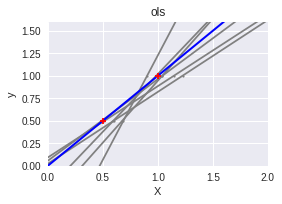

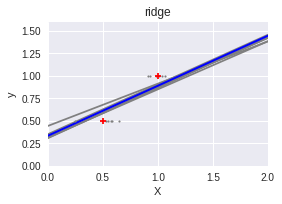

In [0]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1))

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='gray')
        ax.scatter(this_X, y_train, s=3, c='gray', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='red', marker='+', zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

    fig.tight_layout()

plt.show()

# Assignment

Following is data describing characteristics of blog posts, with a target feature of how many comments will be posted in the following 24 hours.

https://archive.ics.uci.edu/ml/datasets/BlogFeedback

Investigate - you can try both linear and ridge. You can also sample to smaller data size and see if that makes ridge more important. Don't forget to scale!

Focus on the training data, but if you want to load and compare to any of the test data files you can also do that.

Note - Ridge may not be that fundamentally superior in this case. That's OK! It's still good to practice both, and see if you can find parameters or sample sizes where ridge does generalize and perform better.

When you've fit models to your satisfaction, answer the following question:

```
Did you find cases where Ridge performed better? If so, describe (alpha parameter, sample size, any other relevant info/processing). If not, what do you think that tells you about the data?
```

You can create whatever plots, tables, or other results support your argument. In this case, your target audience is a fellow data scientist, *not* a layperson, so feel free to dig in!

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip
!unzip BlogFeedback.zip

--2019-01-25 15:26:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2583605 (2.5M) [application/zip]
Saving to: ‘BlogFeedback.zip’

BlogFeedback.zip    100%[===================>]   2.46M  3.34MB/s    in 0.7s    

2019-01-25 15:26:46 (3.34 MB/s) - ‘BlogFeedback.zip’ saved [2583605/2583605]

Archive:  BlogFeedback.zip
  inflating: blogData_test-2012.02.01.00_00.csv  
  inflating: blogData_test-2012.02.02.00_00.csv  
  inflating: blogData_test-2012.02.03.00_00.csv  
  inflating: blogData_test-2012.02.04.00_00.csv  
  inflating: blogData_test-2012.02.05.00_00.csv  
  inflating: blogData_test-2012.02.06.00_00.csv  
  inflating: blogData_test-2012.02.07.00_00.csv  
  inflating: blogData_test-2012.02.08.00_00.csv  
  inflating: blogData_test-20

In [0]:
blog = pd.read_csv('blogData_train.csv', header=None)
blog.head()

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0


In [0]:
#scale the data!
blog = scale(blog)
blog_df = pd.DataFrame(blog)
blog_df.head()


,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,...,-0.454696,2.272362,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,-0.152885
1,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,...,2.199274,-0.440071,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,-0.179406
2,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,...,2.199274,-0.440071,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,-0.179406
3,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,...,-0.454696,2.272362,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,-0.152885
4,0.010876,0.112877,-0.052468,0.138521,-0.139108,0.009598,0.116182,-0.020836,0.368246,-0.119031,...,-0.454696,2.272362,-0.427399,-0.326158,-0.312402,-0.08286,0.0,-0.045171,-0.037836,0.536657


In [0]:
#the target column, listing the number of comments in the first 24 hous after a
#blog was posted
target = blog_df[blog_df.columns[53]]

X = blog_df.drop(blog_df.columns[53], axis=1)
y = blog_df[blog_df.columns[53]]

In [0]:
y.shape

(52397,)

In [0]:
X.shape

(52397, 280)

In [0]:
#see the linear regression results:
#split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

#fit the model
lin_reg_split = LinearRegression().fit(X_train, y_train)

#print the mse
print(mean_squared_error(y_train, lin_reg_split.predict(X_train)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))


0.03758534172065772
0.05356424166507031


The test error with linear regression model is much higher, which tells us about model overfitting to training data. will try to mitigate this by using Ridge regression

In [0]:
ridge_reg = Ridge().fit(X_train, y_train)

#print the mse
print(mean_squared_error(y_train, ridge_reg.predict(X_train)))
print(mean_squared_error(y_test, ridge_reg.predict(X_test)))

0.03758457695233604
0.05356749922309746


the test error is slightly worse, which is expected, since some error is added to the data, let's try to alter alpha value to get better results

In [0]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

0 0.0538180921362293
1 0.05356749922309746
2 0.053573006015058565
3 0.053578237910733816
4 0.0535834641416686
5 0.053588694231711045
6 0.053593907171781856
7 0.053599085963544346
8 0.05360422063996296
9 0.05360930645675298
10 0.05361434198233161
11 0.05361932775094366
12 0.05362426540400211
13 0.053629157162861735
14 0.05363400551124329
15 0.05363881300706002
16 0.05364358217341472
17 0.05364831543788165
18 0.053653015101127036
19 0.05365768332325035
20 0.05366232212067981
21 0.053666933369204944
22 0.053671518810413606
23 0.05367608005985902
24 0.05368061861592577
25 0.05368513586878204
26 0.0536896331090654
27 0.053694111536095296
28 0.053698572265527565
29 0.05370301633640556
30 0.05370744471761809
31 0.053711858313784555
32 0.05371625797060005
33 0.05372064447968678
34 0.05372501858298949
35 0.05372938097675644
36 0.053733732315148726
37 0.05373807321350979
38 0.05374240425133559
39 0.05374672597496728
40 0.05375103890004268
41 0.053755343513724844
42 0.05375964027673614
43 0.05376

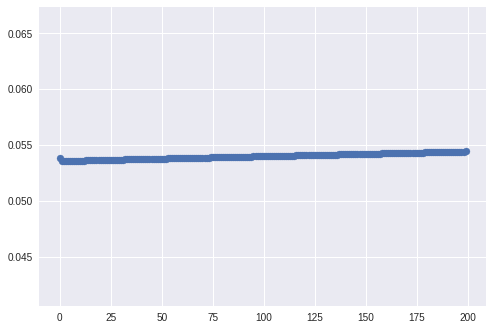

In [0]:
plt.scatter(alphas, mses);

the error was stable at rising, from the plot above it seems the best alpha value is 1 and mse = 0.05356, meaning linear regression could be simpler and better fit for the data. Let's try to sample the initial data and run the above code again

In [0]:
blog_sample = blog_df.sample(frac=0.01, random_state=42)

X_s = blog_sample.drop(blog_sample.columns[53], axis=1)
y_s = blog_sample[blog_sample.columns[53]]
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size = 0.1, random_state=42)


In [0]:
alphas_s = []
mses_s = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_s_train, y_s_train)
  mse = mean_squared_error(y_s_test, ridge_reg_split.predict(X_s_test))
  print(alpha, mse)
  alphas_s.append(alpha)
  mses_s.append(mse)

0 7.887858024697067e+26
1 0.043664245068698336
2 0.04644006278815532
3 0.049265467033699696
4 0.05194441717670451
5 0.05444791299429211
6 0.05678141492424
7 0.05895949863655366
8 0.06099845300013593
9 0.06291378493606652
10 0.06471942056418474
11 0.06642755331145163
12 0.06804874002033694
13 0.06959208159455717
14 0.07106541973956951
15 0.07247552209707965
16 0.07382824602225574
17 0.0751286791237061
18 0.07638125797183389
19 0.07758986756333773
20 0.07875792436269677
21 0.07988844557005191
22 0.08098410694539535
23 0.0820472911693935
24 0.08308012839265162
25 0.0840845303367957
26 0.08506221906626904
27 0.08601475134677801
28 0.0869435393396415
29 0.08784986824536939
30 0.08873491139930798
31 0.08959974323244704
32 0.09044535043765145
33 0.09127264162235904
34 0.09208245568052645
35 0.09287556907729067
36 0.09365270220756919
37 0.09441452496342317
38 0.09516166162326434
39 0.09589469515804086
40 0.09661417103470342
41 0.09732060058491808
42 0.09801446399672943
43 0.09869621297832125
4

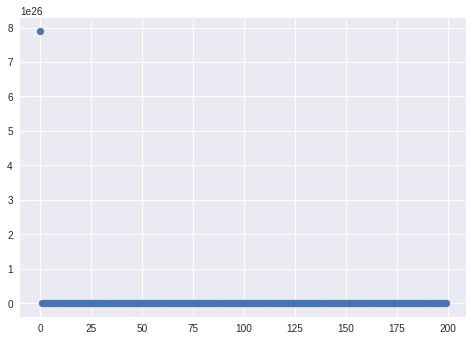

In [0]:
plt.scatter(alphas_s, mses_s);

Indeed, on a sample data, the mse decreased down to  0.04366 with alpha size=1

In [0]:
#Try to test again real test data
import glob
# load all test data from current directory
allFiles = glob.glob("*test*.csv")
list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=None)
    list_.append(df)

blog_test = pd.concat(list_, axis = 0, ignore_index = True)
blog_test.head()

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,34.571430,50.082855,0.0,190.0,7.0,14.523809,31.859990,0.0,156.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.333333,0.992032,0.0,4.0,1.0,0.571429,0.849169,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39.644764,77.917020,0.0,798.0,4.0,16.757700,48.670017,0.0,568.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.630660,17.882992,1.0,259.0,5.0,4.018276,10.396790,0.0,235.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#scale the test data

blog_test = scale(blog_test)
blog_test_df = pd.DataFrame(blog_test)
blog_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,0.027237,0.230339,-0.088207,-0.201772,-0.185128,0.065487,0.231314,-0.087534,-0.183664,-0.091677,...,-0.447284,-0.431348,-0.403394,-0.300907,-0.313689,-0.115268,0.0,-0.041102,-0.029653,-0.142402
1,-0.408824,-0.677760,-0.088207,-0.678264,-0.264585,-0.395584,-0.638753,-0.087534,-0.702009,-0.162461,...,2.235716,-0.431348,-0.403394,-0.300907,-0.313689,-0.115268,0.0,-0.041102,-0.029653,-0.175189
2,0.093795,0.745225,-0.088207,1.355796,-0.224857,0.139308,0.702952,-0.087534,1.212140,-0.127069,...,-0.447284,-0.431348,-0.403394,-0.300907,-0.313689,-0.115268,0.0,-0.041102,-0.029653,-0.175189
3,-0.286850,-0.365305,-0.058140,-0.025008,-0.211614,-0.281679,-0.370876,-0.087534,0.083978,-0.127069,...,2.235716,-0.431348,-0.403394,-0.300907,-0.313689,-0.115268,0.0,-0.041102,-0.029653,-0.175189
4,-0.426317,-0.696111,-0.088207,-0.688512,-0.277828,-0.414467,-0.662578,-0.087534,-0.712173,-0.162461,...,2.235716,-0.431348,-0.403394,-0.300907,-0.313689,-0.115268,0.0,-0.041102,-0.029653,-0.175189


In [0]:
X_tr = blog_df.drop(blog_df.columns[53], axis=1)
y_tr = blog_df[blog_df.columns[53]]

In [0]:
X_te = blog_test_df.drop(blog_test_df.columns[53], axis=1)
y_te = blog_test_df[blog_test_df.columns[53]]

In [0]:
#fit the linear regression model
lin_reg = LinearRegression().fit(X_tr, y_tr)

#print the mse
print(mean_squared_error(y_tr, lin_reg.predict(X_tr)))
print(mean_squared_error(y_te, lin_reg.predict(X_te)))


0.03915768247930148
2.7855672648222202e+20


Absolutely huge difference between train and test data!

In [0]:
alphas_f = []
mses_f = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_tr, y_tr)
  mse = mean_squared_error(y_te, ridge_reg_split.predict(X_te))
  print(alpha, mse)
  alphas_f.append(alpha)
  mses_f.append(mse)

0 3.02996918502618e+22
1 0.03907400648151621
2 0.03912953985044786
3 0.03910901510194724
4 0.03907734678508156
5 0.03904921783615147
6 0.03902764450856592
7 0.03901256747582994
8 0.03900316219911488
9 0.03899851198508664
10 0.03899779742119227
11 0.03900033449886222
12 0.03900556631862824
13 0.039013043015259034
14 0.03902240122663439
15 0.0390333463979522
16 0.03904563845467249
17 0.03905908050130752
18 0.03907350999721845
19 0.039088791882790797
20 0.03910481321541297
21 0.03912147896664416
22 0.039138708712015295
23 0.03915643400831845
24 0.039174596302853346
25 0.039193145256248306
26 0.03921203738869994
27 0.039231234980628395
28 0.03925070517468082
29 0.03927041923802171
30 0.03929035195301895
31 0.0393104811113003
32 0.03933078709157199
33 0.03935125250562882
34 0.039371861900148276
35 0.03939260150445629
36 0.03941345901618897
37 0.03943442341848965
38 0.03945548482347814
39 0.03947663433776486
40 0.03949786394641582
41 0.039519166412596
42 0.03954053519045053
43 0.039561964349

In [0]:
plt.scatter(alphas_f,mses_f);


the best result on the real test data was mse =  0.03900316219911488 with alpha = 8

# Resources and stretch goals

Resources:
- https://www.quora.com/What-is-regularization-in-machine-learning
- https://blogs.sas.com/content/subconsciousmusings/2017/07/06/how-to-use-regularization-to-prevent-model-overfitting/
- https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
- https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
- https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression#111022

Stretch goals:
- Revisit past data you've fit OLS models to, and see if there's an `alpha` such that ridge regression results in a model with lower MSE on a train/test split
- Yes, Ridge can be applied to classification! Check out [sklearn.linear_model.RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), and try it on a problem you previous approached with a different classifier (note - scikit LogisticRegression also automatically penalizes based on the $L^2$ norm, so the difference won't be as dramatic)
- Implement your own function to calculate the full cost that ridge regression is optimizing (the sum of squared residuals + `alpha` times the sum of squared coefficients) - this alone won't fit a model, but you can use it to verify cost of trained models and that the coefficients from the equivalent OLS (without regularization) may have a higher cost